In [34]:
import boto3
from datetime import datetime, timedelta
import json
import matplotlib.pyplot as plt
import requests
import time

In [5]:
# NOTE: You will need to set AWS access keys for the MCP environment
# !env
!export AWS_REGION=us-west-2

In [37]:
%%time
client = boto3.client('logs', region_name='us-west-2')

query = """
fields @timestamp, @message
| filter @message like "cmr.search.api"
| parse @message /concept_id "(?<concept_id>\S+)"/
| stats count(*) as number_queries by concept_id
| sort by number_queries desc
"""

log_group = 'cmr-search-ops'
datetime_str = '05/18/22 00:00:00'
starting_datetime_object = datetime.strptime(datetime_str, '%m/%d/%y %H:%M:%S')

start_query_response = client.start_query(
    logGroupName=log_group,
    startTime=int(starting_datetime_object.timestamp()),
    endTime=int(datetime.now().timestamp()),
    queryString=query,
)

query_id = start_query_response['queryId']

logs_response = None

while logs_response == None or logs_response['status'] == 'Running':
    print('Waiting for query to complete ...')
    time.sleep(60)
    logs_response = client.get_query_results(
        queryId=query_id
    )

Waiting for query to complete ...
Waiting for query to complete ...
Waiting for query to complete ...
Waiting for query to complete ...
Waiting for query to complete ...
Waiting for query to complete ...
Waiting for query to complete ...


ClientError: An error occurred (ExpiredTokenException) when calling the GetQueryResults operation: The security token included in the request is expired

In [28]:
restructured_data = []
for result in logs_response['results']:
    entry_data = {}
    for entry in result:
        entry_data[entry['field']] = entry['value']
    restructured_data.append(entry_data)

restructured_data

[{'concept_id': 'C1202028193-NASA_MAAP', 'number_queries': '540'},
 {'concept_id': 'C1201460047-NASA_MAAP', 'number_queries': '85'},
 {'number_queries': '15'},
 {'concept_id': 'C1201746153-NASA_MAAP', 'number_queries': '6'},
 {'concept_id': 'C1200110769-NASA_MAAP', 'number_queries': '5'},
 {'concept_id': 'C1200000522-NASA_MAAP', 'number_queries': '3'},
 {'concept_id': 'C1201702030-NASA_MAAP', 'number_queries': '3'},
 {'concept_id': 'C1200110729-NASA_MAAP', 'number_queries': '3'},
 {'concept_id': 'C1200110748-NASA_MAAP', 'number_queries': '2'},
 {'concept_id': 'C1201300747-NASA_MAAP', 'number_queries': '2'}]

In [31]:
cmr_url = 'https://cmr.maap-project.org'
collections_search_url = f"{cmr_url}/search/collections.json"
results_dict = {}
for entry in restructured_data:
    # There's 1 blank concept_id entry
    if 'concept_id' in entry:
        cmr_response = requests.get(f"{collections_search_url}?concept_id={entry['concept_id']}")
        number_queries = entry['number_queries']
        short_name = json.loads(cmr_response.text)['feed']['entry'][0]['short_name']
        results_dict[short_name] = int(number_queries)
    

In [32]:
results_dict

{'GEDI_L4A_AGB_Density_V2_1_2056': 540,
 'GEDI02_B': 85,
 'ATL08': 6,
 'Landsat8_SurfaceReflectance': 5,
 'SRTMGL1': 3,
 'GEDI_L3_LandSurface_Metrics_V2_1952': 3,
 'AFLVIS2': 3,
 'ABLVIS1B': 2,
 'ATL03': 2}

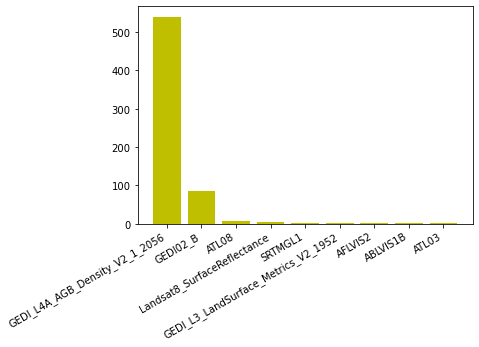

In [33]:
# data set
collections = results_dict.keys()
number_queries = results_dict.values()

plt.bar(collections, number_queries, color='y')
plt.xticks(rotation=30, ha='right')
plt.show()